# Preferential Bayesian Optimization: EI
This notebook demonstrates the use of the Expected Improvement (EI) acquisition function on ordinal (preference) data.

Formulation by Nguyen Quoc Phong.

In [1]:
import numpy as np
import gpflow
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import os
import pickle

from gpflow.utilities import set_trainable, print_summary
gpflow.config.set_default_summary_fmt("notebook")

sys.path.append(os.path.split(os.path.split(os.path.split(os.getcwd())[0])[0])[0]) # Move 3 levels up directory to import PBO
import PBO

In [2]:
objective = PBO.objectives.forrester
objective_low = 0.
objective_high = 1.
objective_name = "Forrester"
acquisition_name = "EI"
experiment_name = "PBO" + "_" + acquisition_name + "_" + objective_name

In [3]:
num_runs = 20
num_evals = 20
num_samples = 100
num_choices = 2
input_dims = 1
num_maximizers = 20
num_init_points = 3
num_inducing_init = 3
num_discrete_per_dim = 10000 # Discretization of continuous input space

In [4]:
results_dir = os.getcwd() + '/results/' + experiment_name + '/'

try:
    # Create target Directory
    os.makedirs(results_dir)
    print("Directory " , results_dir ,  " created ") 
except FileExistsError:
    print("Directory " , results_dir ,  " already exists")

Directory  /home/sebtsh/PBO/notebooks/EI/results/PBO_EI_Forrester/  already exists


Plot of the Forrester function (global min at ~0.757):

(-0.0, 1.0)

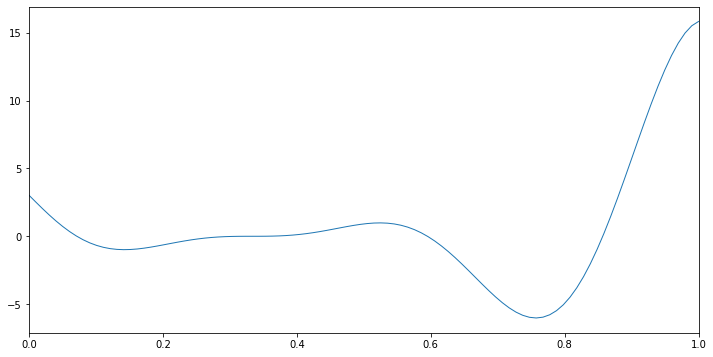

In [5]:
xx = np.linspace(0.0, 1.0, 100).reshape(100, 1)
plt.figure(figsize=(12, 6))
plt.plot(xx, objective(xx), 'C0', linewidth=1)
plt.xlim(-0.0, 1.0)

In [6]:
def plot_gp(model, X, y, title, cmap="Spectral"):
    #Plotting code from GPflow authors

    ## generate test points for prediction
    xx = np.linspace(-0.1, 1.1, 100).reshape(100, 1)  # test points must be of shape (N, D)

    ## predict mean and variance of latent GP at test points
    mean, var = model.predict_f(xx)

    ## generate 10 samples from posterior
    samples = model.predict_f_samples(xx, 10)  # shape (10, 100, 1)

    ## plot 
    plt.figure(figsize=(12, 6))
    plt.plot(X, y, 'kx', mew=2)
    plt.plot(xx, mean, 'C0', lw=2)
    plt.fill_between(xx[:,0],
                     mean[:,0] - 1.96 * np.sqrt(var[:,0]),
                     mean[:,0] + 1.96 * np.sqrt(var[:,0]),
                     color='C0', alpha=0.2)

    plt.plot(xx, samples[:, :, 0].numpy().T, 'C0', linewidth=.5)
    plt.xlim(-0.1, 1.1)
    plt.title(title)

    plt.savefig(fname=results_dir + title + ".png")

In [7]:
def get_noisy_observation(X, objective):
    f = PBO.objectives.objective_get_f_neg(X, objective)
    return PBO.observation_model.gen_observation_from_f(X, f, 1)

In [8]:
def train_and_visualize(X, y, num_inducing, title):
    
    # Train model with data
    q_mu, q_sqrt, u, inputs, k, indifference_threshold = PBO.models.learning_stochastic.train_model_fullcov(X, y, 
                                                                         num_inducing=num_inducing,
                                                                         obj_low=objective_low,
                                                                         obj_high=objective_high,
                                                                         lengthscale=0.05,
                                                                         num_steps=3000)
    likelihood = gpflow.likelihoods.Gaussian()
    model = PBO.models.learning.init_SVGP_fullcov(q_mu, q_sqrt, u, k, likelihood)
    u_mean = q_mu.numpy()
    inducing_vars = u.numpy()
    
    # Visualize model
    plot_gp(model, inducing_vars, u_mean, title)
    
    return model, inputs, u_mean, inducing_vars

In [9]:
def uniform_grid(input_dims, num_discrete_per_dim, low=0., high=1.):
    """
    Returns an array with all possible permutations of discrete values in input_dims number of dimensions.
    :param input_dims: int
    :param num_discrete_per_dim: int
    :param low: int
    :param high: int
    :return: tensor of shape (num_discrete_per_dim ** input_dims, input_dims)
    """
    num_points = num_discrete_per_dim ** input_dims
    out = np.zeros([num_points, input_dims])
    discrete_points = np.linspace(low, high, num_discrete_per_dim)
    for i in range(num_points):
        for dim in range(input_dims):
            val = num_discrete_per_dim ** (dim)
            out[i, dim] = discrete_points[int((i // val) % num_discrete_per_dim)]
    return out

This function is our main metric for the performance of the acquisition function: The closer the model's best guess to the target (in this case, the global minimum of the Forrester function), the better.

In [10]:
def best_guess(model):
    """
    :return: tensor of shape (input_dims) a GP model's best guess of the global maximum of f.
    """
    xx = uniform_grid(input_dims, num_discrete_per_dim, low=objective_low, high=objective_high)
    res = model.predict_f(xx)[0].numpy()
    return xx[np.argmax(res)]

Store the results in these arrays:

In [11]:
num_data_at_end = int((num_init_points-1) * num_init_points / 2 + num_evals)
X_results = np.zeros([num_runs, num_data_at_end, num_choices, input_dims])
y_results = np.zeros([num_runs, num_data_at_end, 1, input_dims])
best_guess_results = np.zeros([num_runs, num_evals, input_dims])

Create the initial values for each run:

In [12]:
np.random.seed(0)
init_points = np.random.uniform(low=objective_low, high=objective_high, size=[num_runs, num_init_points, input_dims])
num_combs = int((num_init_points-1) * num_init_points / 2)
init_vals = np.zeros([num_runs, num_combs, num_choices, input_dims])
for run in range(num_runs):
    cur_idx = 0
    for init_point in range(num_init_points-1):
        for next_point in range(init_point+1, num_init_points):
            init_vals[run, cur_idx, 0] = init_points[run, init_point]
            init_vals[run, cur_idx, 1] = init_points[run, next_point]
            cur_idx += 1

The following loops carry out the Bayesian optimization algorithm over a number of runs, with a fixed number of evaluations per run.

Beginning run 1
Indifference_threshold is trainable.
Instructions for updating:
Use tf.identity instead.
Negative ELBO at step 0: 2.935370471192799 in 0.1756s
Negative ELBO at step 500: 2.326293562024815 in 50.9529s
Negative ELBO at step 1000: 2.0496192304955425 in 62.8241s
Negative ELBO at step 1500: 1.9957258564686176 in 60.8662s
Negative ELBO at step 2000: 2.130071216447619 in 67.2052s
Negative ELBO at step 2500: 2.1688173029330553 in 59.2329s
Beginning evaluation 0
Maximizer:
[[0.]]
Evaluation 0: Next query is [[0.        ]
 [0.99884701]] with EI value of [0.32314352]
Evaluation 0: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 3.6891000537910497 in 0.1953s
Negative ELBO at step 500: 2.6964401182776916 in 73.1784s
Input matrix is not invertible. [Op:MatrixTriangularSolve]
<tf.Variable 'q_mu:0' shape=(4, 1) dtype=float64, numpy=
array([[-0.48188809],
       [ 0.50440839],
       [ 0.16173334],
       [ 0.02874109]])>
<tf.Variable 'q_sqrt_latent:0' shape

name,class,transform,prior,trainable,shape,dtype,value
SquaredExponential.variance,Parameter,Softplus,,True,(),float64,nan
SquaredExponential.lengthscale,Parameter,Softplus + Shift,,True,"(1,)",float64,[nan]


ValueError: 

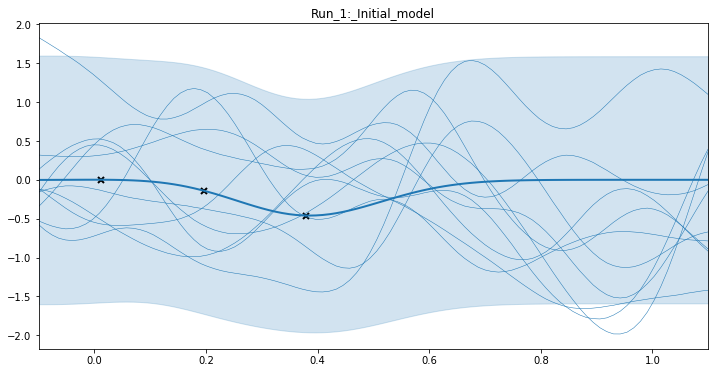

In [14]:
for run in range(num_runs):
    print("Beginning run %s" % (run))
    
    X = init_vals[run]
    y = get_noisy_observation(X, objective)
    
    model, inputs, u_mean, inducing_vars = train_and_visualize(X, y, num_inducing_init, "Run_{}:_Initial_model".format(run))

    for evaluation in range(num_evals):
        print("Beginning evaluation %s" % (evaluation)) 

        # Get incumbent maximizer
        maximizer = np.expand_dims(best_guess(model), axis=0)  # (1, input_dims)
        
        print("Maximizer:")
        print(maximizer)
        
        # Sample possible next input points. In EI, all queries are a pair with the incumbent maximizer as the 
        # first point and a next input point as the second point
        
        samples = np.random.uniform(low=objective_low,
                                    high=objective_high,
                                    size=(num_samples, input_dims))
        
        # Calculate EI vals
        ei_vals = PBO.acquisitions.ei.EI(model, maximizer, samples)
        
        # Select query that maximizes EI
        next_idx = np.argmax(ei_vals)
        next_query = np.zeros((num_choices, input_dims))
        next_query[0, :] = maximizer  # EI only works in binary choices
        next_query[1, :] = samples[next_idx]
        print("Evaluation %s: Next query is %s with EI value of %s" % (evaluation, next_query, ei_vals[next_idx]))

        X = np.concatenate([X, [next_query]])
        # Evaluate objective function
        y = np.concatenate([y, get_noisy_observation(np.expand_dims(next_query, axis=0), objective)], axis=0)
        
        print("Evaluation %s: Training model" % (evaluation))
        model, inputs, u_mean, inducing_vars = train_and_visualize(X, y, 
                                                                   num_inducing_init + evaluation + 1, 
                                                                   "Run_{}_Evaluation_{}".format(run, evaluation))

        best_guess_results[run, evaluation, :] = best_guess(model)

    X_results[run] = X
    y_results[run] = y

In [22]:
X

array([[[0.54488318],
        [0.4236548 ]],

       [[0.54488318],
        [0.64589411]],

       [[0.4236548 ],
        [0.64589411]],

       [[0.        ],
        [0.99884701]]])

In [25]:
y

array([[[0.54488318]],

       [[0.64589411]],

       [[0.64589411]],

       [[0.        ]]])

In [69]:
X1 = X.copy()

In [70]:
X1[3][0] = 0.1

In [71]:
X1

array([[[0.54488318],
        [0.4236548 ]],

       [[0.54488318],
        [0.64589411]],

       [[0.4236548 ],
        [0.64589411]],

       [[0.1       ],
        [0.99884701]]])

In [63]:
y1 = y.copy()

In [66]:
y1[3] = 0.1

In [67]:
y1

array([[[0.54488318]],

       [[0.64589411]],

       [[0.64589411]],

       [[0.1       ]]])

In [77]:
vals2 = train_model_fullcov(X1, y1, 
                                                                         num_inducing=4,
                                                                         obj_low=objective_low,
                                                                         obj_high=objective_high,
                                                                         lengthscale=0.05,
                                                                         num_steps=300)

Indifference_threshold is trainable.
0
Negative ELBO at step 0: 3.9896132226812417 in 0.2999s
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
25

In [78]:
vals2

[(array([[0.],
         [0.],
         [0.],
         [0.]]),
  array([[[1., 0., 0., 0.],
          [0., 1., 0., 0.],
          [0., 0., 1., 0.],
          [0., 0., 0., 1.]]]),
  array([[0.18024599],
         [0.64495305],
         [0.3011193 ],
         [0.100001  ]]),
  array([[0.64589411],
         [0.54488318],
         [0.4236548 ],
         [0.1       ],
         [0.99884701]]),
  array([0.05]),
  1.0,
  4.098923471369641),
 (array([[ 0.00099993],
         [ 0.001     ],
         [-0.00099998],
         [ 0.00099999]]),
  array([[[ 0.99900008,  0.        ,  0.        ,  0.        ],
          [ 0.00099998,  0.99900001,  0.        ,  0.        ],
          [ 0.00099999, -0.00099996,  0.99900002,  0.        ],
          [ 0.00099999,  0.00099998, -0.00099989,  0.99900001]]]),
  array([[0.18124599],
         [0.64595304],
         [0.30211929],
         [0.099001  ]]),
  array([[0.64589411],
         [0.54488318],
         [0.4236548 ],
         [0.1       ],
         [0.99884701]])

In [40]:
len(vals2)

6

In [36]:
len(vals)

159

In [45]:
vals

[(<tf.Variable 'q_mu:0' shape=(4, 1) dtype=float64, numpy=
  array([[ 0.14335867],
         [ 0.0159952 ],
         [ 0.14119985],
         [-0.00498463]])>,
  <tf.Variable 'q_sqrt_latent:0' shape=(1, 4, 4) dtype=float64, numpy=
  array([[[ 0.92664723,  0.        ,  0.        ,  0.        ],
          [-0.00322527,  0.97858129,  0.        ,  0.        ],
          [ 0.01201284, -0.01904899,  0.91431422,  0.        ],
          [-0.00173271, -0.00338486,  0.08029921,  0.90563359]]])>,
  <tf.Variable 'u:0' shape=(4, 1) dtype=float64, numpy=
  array([[nan],
         [nan],
         [nan],
         [nan]])>,
  array([[0.64589411],
         [0.54488318],
         [0.4236548 ],
         [0.        ],
         [0.99884701]]),
  <gpflow.Parameter 'Variable:0' dtype=float64 unconstrained-shape=(1,) unconstrained-value=[nan] constrained-shape=(1,) constrained-value=[nan]>,
  <gpflow.Parameter 'Variable:0' dtype=float64 unconstrained-shape=() unconstrained-value=nan constrained-shape=() constrain

In [33]:
k

NameError: name 'k' is not defined

In [76]:
# todo
#     1. use samples to compute the objective function
#         elbo_fullcov(q_mu, q_sqrt_latent, inducing_variables, D_idxs, max_idxs, kernel, inputs)
#        then it can works for different number of choices
#     2. val_to_idxs, populate_dicts: need to adaptive to different number of choices
#         by converting some to list
#     2. check function q_f to see if the implementation is correct
#         checked: correct
"""
    forester_get_Y:
        as X is a list, change the function!
    sample maximizers:
        change observations from inducing input, inducing variables
        to distribution of inducing variables

Given ordinal (preference) data consisting of sets of input points and a most preferred input point for every such set,
the train_model function learns variational parameters that approximate the distribution of a latent function f over
all input points present in the data, which can be used to construct GP models to approximate f over the entire input
space.
Formulation by Nguyen Quoc Phong.
"""

import time

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

import gpflow
from gpflow.utilities import set_trainable


def elbo_fullcov(q_mu,
                q_sqrt_latent,
                inducing_inputs,
                D_idxs,
                max_idxs,
                kernel,
                inputs,
                indifference_threshold,
                n_inducing_sample=50,
                n_f_given_inducing_sample=30):
    """
    Calculates the ELBO for the PBO formulation, using a full covariance matrix.
    :param q_mu: tensor with shape (num_inducing, 1)
    :param q_sqrt_latent: tensor with shape (1, num_inducing, num_inducing). Will be forced into lower triangular
        matrix such that q_sqrt @ q_sqrt^T represents the covariance matrix of inducing variables
    :param inducing_inputs: tensor with shape (num_inducing, input_dims)
    :param D_idxs: tensor with shape (num_data, num_choices, 1)
        Input data points, that are indices into q_mu and q_var for tf.gather_nd
    :param max_idxs: tensor with shape (num_data, 1)
        Selection of most preferred input point for each collection of data points, that are indices into
        q_mu and q_var
    :param kernel: gpflow kernel to calculate covariance matrix for KL divergence
    :param inputs: tensor of shape (num_inputs, input_dims) with indices corresponding to that of D_idxs and max_idxs
    :return: tensor of shape ()
    """
    Kmm = kernel.K(inducing_inputs)

    logdet_Kmm = tf.linalg.logdet(Kmm)
    invKmm = cholesky_matrix_inverse(Kmm)

    num_data = D_idxs.size()

    # 1. Sample from q(u)
    standard_mvn = tfp.distributions.MultivariateNormalDiag(
            loc=tf.zeros(tf.shape(q_mu)[0], dtype=tf.float64),
            scale_diag=tf.ones(tf.shape(q_mu)[0], dtype=tf.float64))

    standard_mvn_samples = standard_mvn.sample(n_inducing_sample)
    # (n_inducing_sample, num_inducing)

    q_sqrt = tf.linalg.band_part(q_sqrt_latent, -1, 0)  # Force into lower triangular
    q_full = q_sqrt @ tf.linalg.matrix_transpose(q_sqrt)  # (1, num_data, num_data)
    inv_q_full = cholesky_matrix_inverse(tf.squeeze(q_full, axis=0))

    posterior_inducing_samples = q_sqrt @ tf.expand_dims(standard_mvn_samples, axis=-1) + q_mu
    # (n_inducing_sample, num_inducing, 1)

    # 2. p(f|u) where u are samples from q(u)
    f_mean_given_inducing_sample, f_cov_given_inducing_sample = p_f_given_u(
            posterior_inducing_samples,
            inducing_inputs, kernel, inputs, invKmm)
    # f_mean: (n_inducing_sample, num_inputs)
    # f_cov: (num_inputs, num_inputs)

    # 3. KL[q(u) || p(u)] = E_{q(u)} [log q(u)] - [log p(u)]
    zero_mean_inducing_samples = posterior_inducing_samples - q_mu
    # (n_inducing_sample, num_inducing, 1)

    klterm = -0.5 * tf.reduce_mean(
        tf.linalg.logdet(q_full)
        + tf.transpose(zero_mean_inducing_samples, perm=[0,2,1]) @ inv_q_full @ zero_mean_inducing_samples
        - logdet_Kmm
        - tf.transpose(posterior_inducing_samples, perm= [0,2,1]) @ invKmm @ posterior_inducing_samples
    )

    def body(i, likelihood):
        idxs = tf.squeeze(D_idxs.read(i))
        max_idx = max_idxs[i]
        num_choice = tf.shape(idxs)[0]

        fi_cov = tf.gather(
            tf.gather(f_cov_given_inducing_sample, indices=idxs, axis=0),
            indices=idxs, axis=1)
        # (num_choice, num_choice)

        fi_mean = tf.gather(f_mean_given_inducing_sample, indices=idxs, axis=1)
        # (n_inducing_sample, num_choice)

        standard_mvn_i = tfp.distributions.MultivariateNormalDiag(
                loc=tf.zeros_like(idxs, dtype=tf.float64),
                scale_diag=tf.ones_like(idxs, dtype=tf.float64))

        standard_mvn_i_samples = standard_mvn_i.sample(n_f_given_inducing_sample)
        # (n_f_given_inducing_sample, num_choice)

        eigvalues, eigvects = tf.linalg.eigh(fi_cov)
        eigvalues = tf.clip_by_value(eigvalues, clip_value_min=0., clip_value_max=np.infty)
        transform_mat = eigvects @ tf.linalg.diag(tf.sqrt(eigvalues))

        zero_mean_f_samples = tf.squeeze(transform_mat @ tf.expand_dims(standard_mvn_i_samples, axis=-1), axis=-1)
        # (n_f_given_inducing_sample, num_choice)

        f_samples = tf.expand_dims(zero_mean_f_samples, axis=1) + fi_mean
        # (n_f_given_inducing_sample, n_inducing_sample, num_choice)

        # implementing a threshold for the choice of indifference
        mask_mat = tf.eye(num_choice, dtype=tf.float64)
        diff_mat = (1.0 - mask_mat) * indifference_threshold

        def true_fn(max_idx, f_samples, diff_mat):
            f_samples = f_samples + tf.gather(diff_mat, indices=max_idx, axis=0)

            return tf.reduce_mean(
                    tf.gather(f_samples, indices=max_idx, axis=-1)
                    - tf.reduce_logsumexp(f_samples, axis=-1))

        def false_fn(f_samples, mask_mat, diff_mat):
            max_idx_f_samples = tf.squeeze(mask_mat @ tf.expand_dims(f_samples, axis=-1), axis=-1)
            # (n_f_given_inducing_sample, n_inducing_sample, num_choice)

            all_f_samples = tf.expand_dims(f_samples, axis=-1) + tf.gather(diff_mat, indices=max_idx, axis=0)
            # (n_f_given_inducing_sample, n_inducing_sample, num_choice, num_choice)

            all_choice_logprob = max_idx_f_samples - tf.reduce_logsumexp(all_f_samples, axis=-2)
            # (n_f_given_inducing_sample, n_inducing_sample, num_choice)

            indifference_prob = 1.0 - tf.exp( tf.reduce_logsumexp(all_choice_logprob, axis=-1) )
            indifference_prob = tf.clip_by_value(indifference_prob, clip_value_min=1e-50, clip_value_max=1.0 - 1e-50)
            indifference_logprob = tf.math.log(indifference_prob)
            # (n_f_given_inducing_sample, n_inducing_sample)

            return tf.reduce_mean( indifference_logprob )

        likelihood_i = tf.cond(max_idx >= 0,
            lambda: true_fn(max_idx, f_samples, diff_mat),
            lambda: false_fn(f_samples, mask_mat, diff_mat))

        likelihood = likelihood + likelihood_i

        return i+1, likelihood

    cond = lambda i, _: i < num_data

    _, likelihood = tf.while_loop(
            cond,
            body,
            (0, tf.constant(0.0, dtype=tf.float64)),
            parallel_iterations=10)

    elbo = likelihood - klterm

    return elbo


def cholesky_matrix_inverse(A):
    """
    :param A: Symmetric positive-definite matrix, tensor of shape (n, n)
    :return: Inverse of A, tensor of shape (n, n)
    """
    L = tf.linalg.cholesky(A)
    L_inv = tf.linalg.triangular_solve(L, tf.eye(A.shape[0], dtype=tf.float64))
    return tf.linalg.matrix_transpose(L_inv) @ L_inv


def p_f_given_u(inducing_vars, inducing_inputs, kernel, inputs, invKmm_prior):
    """
    Calculates the mean and covariance of the joint distriubtion p(f|u)
    :param inducing_vars: tensor with shape (nsample,num_inducing,1)
    :param inducing_inputs: tensor with shape (num_inducing, input_dims)
    :param kernel: gpflow kernel to calculate covariance matrix for KL divergence
    :param inputs: tensor of shape (num_inputs, input_dims) with indices corresponding to that of D_idxs and max_idxs
    :return: (tensor of shape (nsample,num_inputs), tensor of shape (num_inputs, num_inputs))
    """
    Knm = kernel.K(inputs, inducing_inputs)  # (n, m)
    A = Knm @ invKmm_prior  # (n, m)

    f_mean = tf.squeeze(A @ inducing_vars, axis=-1)
    # (nsample, num_inducing)

    Knn = kernel.K(inputs)
    f_cov = Knn - A @ tf.transpose(Knm)
    # (num_inputs, num_inputs)

    return f_mean, f_cov


def q_f(q_mu, q_sqrt_latent, inducing_variables, kernel, inputs):
    """
    Calculates the mean and covariance of the joint distribution q(f)
    :param q_mu: tensor with shape (num_inducing, 1)
    :param q_sqrt_latent: tensor with shape (1, num_inducing, num_inducing). Will be forced into lower triangular
        matrix such that q_sqrt @ q_sqrt^T represents the covariance matrix of inducing variables
    :param inducing_variables: tensor with shape (num_inducing, input_dims)
    :param kernel: gpflow kernel to calculate covariance matrix for KL divergence
    :param inputs: tensor of shape (num_inputs, input_dims) with indices corresponding to that of D_idxs and max_idxs
    :return: (tensor of shape (num_inputs), tensor of shape (num_inputs, num_inputs))
    """

    q_sqrt = tf.linalg.band_part(q_sqrt_latent, -1, 0)  # Force into lower triangular
    q_full = q_sqrt @ tf.linalg.matrix_transpose(q_sqrt)  # (1, num_data, num_data)

    Kmm = kernel.K(inducing_variables)  # (m, m)
    Kmm_inv = cholesky_matrix_inverse(Kmm)

    Knm = kernel.K(inputs, inducing_variables)  # (n, m)
    A = Knm @ Kmm_inv  # (n, m)

    f_mean = tf.squeeze(A @ q_mu, axis=-1)

    Knn = kernel.K(inputs)
    S = tf.squeeze(q_full, axis=0)
    f_cov = Knn + (A @ (S - Kmm) @ tf.linalg.matrix_transpose(A))

    return f_mean, f_cov


def populate_dicts(D_vals):
    """
    Populates dictionaries to assign an index to each value seen in the training data.
    :param D_vals: [k] list of 2-d ndarray [:,d] (to allow different num_choice for different observations)
    """
    idx_to_val_dict = {}
    val_to_idx_dict = {}

    D_vals_list = np.concatenate(D_vals, axis=0)
    D_vals_list_tuples = [tuple(i) for i in D_vals_list]
    D_vals_set = set(D_vals_list_tuples)

    for val in D_vals_set:
        val_to_idx_dict[val] = len(val_to_idx_dict)
        idx_to_val_dict[len(val_to_idx_dict)-1] = val

    return idx_to_val_dict, val_to_idx_dict


def val_to_idx(D_vals, max_vals, val_to_idx_dict):
    """
    Converts training data from real values to index format using dictionaries.
    Returns D_idxs (tensor with shape (k, num_choices, 1))
        and max_idxs (tensor with shape (k, 1)):
            max_idxs[i,0] is argmax of D_idxs[i,:,0]
    :param D_vals: [k] list of ndarray [:,d]
    :param max_vals: [k] list of ndarray [1,d]
    """

    k = len(D_vals)

    max_idxs = np.zeros(k, dtype=np.int32)

    for i in range(k):
        if max_vals[i] is not None:
            diff = np.sum(np.square(D_vals[i] - max_vals[i]), axis=1)
            max_idxs[i] = np.where(diff < 1e-30)[0]
        else:
            max_idxs[i] = -1

    max_idxs = tf.constant(max_idxs)

    D_idxs = tf.TensorArray(dtype=tf.int32, size=k, name='D_idxs', infer_shape=False, clear_after_read=False)

    for i in range(k):
        np.stack([ [val_to_idx_dict[tuple(datum)]] for datum in D_vals[i] ])

    cond = lambda i, _: i < k
    body = lambda i, D_idxs: \
        (i+1,
         D_idxs.write(
            i,
            tf.constant([ val_to_idx_dict[tuple(datum)] for datum in D_vals[i] ], dtype=tf.int32)
            )
        )

    _, D_idxs = tf.while_loop(cond, body, (0, D_idxs))

    return D_idxs, max_idxs


def train_model_fullcov(X,
                        y,
                        num_inducing,
                        obj_low,
                        obj_high,
                        lengthscale=1.,
                        num_steps=5000,
                        indifference_threshold=None):
    """
    if indifference_threshold is None:
        indifference_threshold is trained with maximum likelihood estimation
    else:
        indifference_threshold is fixed
    :param X: np array with shape (num_data, num_choices, input_dims). Ordinal data
    :param y: np array with shape (num_data, input_dims). Most preferred input for each set of inputs. Each y value must
    match exactly to one of the choices in its corresponding X entry
    :param num_inducing: number of inducing variables to use
    :param obj_low: int. Floor of possible inducing point value in each dimension
    :param obj_high: int. Floor of possible inducing point value in each dimension
    :param lengthscale: float. Lengthscale to initialize RBF kernel with
    :param num_steps: int that specifies how many optimization steps to take when training model
    :param indifference_threshold:
    """
    input_dims = X.shape[2]
    idx_to_val_dict, val_to_idx_dict = populate_dicts(X)
    D_idxs, max_idxs = val_to_idx(X, y, val_to_idx_dict)

    n = len(val_to_idx_dict.keys())
    inputs = np.array([idx_to_val_dict[i] for i in range(n)])

    # Initialize variational parameters

    q_mu = tf.Variable(np.zeros([num_inducing, 1]), name="q_mu", dtype=tf.float64)
    q_sqrt_latent = tf.Variable(np.expand_dims(np.eye(num_inducing), axis=0), name="q_sqrt_latent", dtype=tf.float64)
    kernel = gpflow.kernels.RBF(lengthscale=[lengthscale for i in range(input_dims)])
    kernel.lengthscale.transform = gpflow.utilities.bijectors.positive(lower=gpflow.default_jitter())
    u = tf.Variable(np.array([[0.18024599],
         [0.64495305],
         [0.3011193 ],
         [0.100001        ]]),
                    name="u",
                    dtype=tf.float64,
                    constraint=lambda x: tf.clip_by_value(x, obj_low, obj_high))

    is_threshold_trainable = (indifference_threshold is None)

    if is_threshold_trainable:
        indifference_threshold = tf.Variable(0.1, dtype=tf.float64,
                        constraint=lambda x: tf.clip_by_value(x,
                                                clip_value_min=0.0,
                                                clip_value_max=np.infty))

    neg_elbo = lambda: -elbo_fullcov(q_mu=q_mu,
                                     q_sqrt_latent=q_sqrt_latent,
                                     inducing_inputs=u,
                                     D_idxs=D_idxs,
                                     max_idxs=max_idxs,
                                     kernel=kernel,
                                     inputs=inputs,
                                     indifference_threshold=indifference_threshold,
                                     n_inducing_sample=50,
                                     n_f_given_inducing_sample=50)

    optimizer = tf.keras.optimizers.Adam()

    if is_threshold_trainable:
        print("Indifference_threshold is trainable.")
        trainable_vars = [q_mu, q_sqrt_latent, u, indifference_threshold] + list(kernel.trainable_variables)
    else:
        print("Indifference_threshold is fixed at {}".format(indifference_threshold))
        trainable_vars = [q_mu, q_sqrt_latent, u] + list(kernel.trainable_variables)

    start_time = time.time()

    vals = []

    try:
        for i in range(num_steps):
            vals.append((q_mu.numpy(), q_sqrt_latent.numpy(), u.numpy(), inputs, kernel.lengthscale.numpy(), kernel.variance.numpy(), neg_elbo().numpy()))
            print(i)
            optimizer.minimize(neg_elbo, var_list=trainable_vars)

            if i % 500 == 0:
                print('Negative ELBO at step {}: {} in {:.4f}s'.format(i,
                           neg_elbo().numpy(),
                           time.time() - start_time))

                start_time = time.time()
    except tf.errors.InvalidArgumentError as err:
        print(err)
        print(q_mu)
        print(q_sqrt_latent)
        print(u)
        print(inputs)
        gpflow.utilities.print_summary(kernel)
        return vals
        
    return vals

    if is_threshold_trainable:
        return q_mu, tf.linalg.band_part(q_sqrt_latent, -1, 0), u, inputs, kernel, indifference_threshold  # q_mu and q_sqrt
    else:
        return q_mu, tf.linalg.band_part(q_sqrt_latent, -1, 0), u, inputs, kernel  # q_mu and q_sqrt


def init_SVGP_fullcov(q_mu, q_sqrt, inducing_variables, kernel, likelihood):
    """
    Returns a gpflow SVGP model using the values obtained from train_model.
    :param q_mu: np array or tensor of shape (num_inputs, 1)
    :param q_sqrt: np array or tensor of shape (num_inputs, num_inputs). Lower triangular matrix
    :param inducing_variables: tensor of shape (num_inducing, input_dims)
    :param inputs: np array or tensor of shape (num_inputs, input_dims)
    :param kernel: gpflow kernel
    :param likelihood: gpflow likelihood
    """

    model = gpflow.models.SVGP(kernel=kernel,
                               likelihood=likelihood,
                               inducing_variable=inducing_variables,
                               whiten=False)

    model.q_mu.assign(q_mu)
    model.q_sqrt.assign(q_sqrt)

    # Set so that the parameters learned do not change if further optimization over
    # other parameters is performed
    set_trainable(model.q_mu, False)
    set_trainable(model.q_sqrt, False)
    set_trainable(model.inducing_variable.Z, False)

    return model



In [ ]:
pickle.dump((X_results, y_results, best_guess_results), open(results_dir + "Xybestguess.p", "wb"))

In [ ]:
def dist(x, y):
    """
    x and y have shape (..., input_dims)
    """
    return np.sqrt(np.sum((x - y) * (x - y), axis=-1))

In [ ]:
xx = uniform_grid(input_dims, num_discrete_per_dim, low=objective_low, high=objective_high)
global_min = xx[np.argmin(objective(xx))][0]

for i in range(best_guess_results.shape[0]):
    diff_from_min = dist(best_guess_results[i], global_min)
    
    x_axis = list(range(num_combs+1, num_combs+1+num_evals))
    plt.figure(figsize=(12, 6))
    plt.plot(x_axis, diff_from_min, 'kx', mew=2)
    plt.xticks(x_axis)
    plt.xlabel('Evaluations', fontsize=18)
    plt.ylabel('Best guess distance', fontsize=16)
    plt.title("Run %s" % i)
    plt.show()